In [27]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
import xgboost as xgb
from xgboost_distribution import XGBDistribution
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option('display.width', 10000)

# Change the project name here to your project name in your account
# client = bigquery.Client(project="ambient-sylph-426620-g6") # Odele

client = bigquery.Client(project="plucky-snowfall-438110-f2")

In [29]:
query = '''
    WITH purchases as(
        SELECT distinct
            fullVisitorId as user_id
            ,PARSE_DATETIME("%Y%m%d %H:%M:%S", CONCAT(date, ' ' ,hour,':',minute,':00')) AS datetime
            ,product.productSKU AS product_id
            ,product.v2ProductName AS product_name
            ,product.v2ProductCategory AS product_category
            ,product.productPrice/1000000 AS product_price
            ,product.productQuantity AS product_qty
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits
        LEFT JOIN UNNEST(hits.product) AS product ON TRUE
        WHERE true
            and hits.eCommerceAction.action_type  = '5'
            and product.productQuantity > 0
            and PARSE_DATETIME("%Y%m%d %H:%M:%S", CONCAT(date, ' ' ,hour,':',minute,':00')) < date '2017-08-01'
    )
    SELECT 
        date_trunc(datetime, day) as ymd
        ,product_id
        ,product_name
        ,product_category product_category_temp
        ,product_price
        ,sum(product_qty) as daily_qty
        ,count(distinct user_id) as daily_user_cnt
    FROM purchases
    GROUP BY 2,1,3,4,5
    ORDER BY 1,2,3
    
'''

rows = client.query(query)
daily_sales = rows.to_dataframe()
raw_ga_data = rows.to_dataframe()

## 1. Querying product sales from GA

In [32]:
daily_sales["ymd"] = pd.to_datetime(daily_sales["ymd"])
daily_sales.replace('(not set)', np.nan, inplace = True)
daily_sales['product_category_temp'].replace('${productitem.product.origCatName}', np.nan, inplace = True)
daily_sales['product_category_temp'].replace(['Tumblers', 'Bottles', 'Google'], 'Drinkware', inplace = True)
daily_sales['product_category_temp'].replace(['More Bags', 'Backpacks'], 'Bags', inplace = True)
daily_sales['product_category_temp'].replace('Android', 'Apparel', inplace = True)
daily_sales.loc[daily_sales["product_name"].str.contains(r"Waze.*(Men's|Women's|Socks)", case = True, na = False), "product_category_temp"] = "Apparel"
daily_sales['product_category_temp'].replace('Waze', 'Electronics', inplace = True)
daily_sales.loc[daily_sales["product_name"].str.contains(r"(Shirt|Sleeve|Tee|Jacket|Pullover|Hoodie|Tank|Vest|Onesie|Pants|Hood|Polo)", case = True, na = False), "product_category_temp"] = "Apparel"
daily_sales.loc[daily_sales["product_name"].str.contains(r"(oz|Bottle|Cup)", case = True, na = False), "product_category_temp"] = "Drinkware"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Journal|Notebook", case = True, na = False), "product_category_temp"] = "Notebooks & Journals"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Bag|Backpack|Tote|Rucksack", case = True, na = False), "product_category_temp"] = "Bags"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Gift Card", case = True, na = False), "v"] = "Gift Cards"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Electronics|Device|Headphones|Earbuds|Earphones", case = True, na = False), "product_category_temp"] = "Electronics"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Cap|Hat", case = True, na = False), "product_category_temp"] = "Headgear"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Pen", case = True, na = False), "product_category_temp"] = "Office"
daily_sales["product_id"] = daily_sales['product_id'].astype("string")
product_category_mode = daily_sales.groupby(["product_id", "product_price"])["product_category_temp"].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index(name="product_category")
daily_sales = daily_sales.merge(product_category_mode, on = ["product_id", "product_price"], how = "left")
daily_sales = daily_sales.groupby(["ymd", "product_id", "product_price", "product_category"])[["daily_qty", "daily_user_cnt"]].sum().reset_index()

daily_sales.dropna(subset = ['product_category'], inplace = True)

## 2. Grouping by product category and date to get sales per day

In [35]:
# Grouping the sales data by product category and date
category_sales = daily_sales.groupby(['ymd', 'product_category']).agg(
    daily_qty_sum=('daily_qty', 'sum'),  # Sum of quantities sold per day
    avg_price=('product_price', 'mean')  # Average price per day
).reset_index()

# Displaying the first few rows
category_sales.head()


,ymd,product_category,daily_qty_sum,avg_price
0,2016-08-01,Accessories,9,4.490000
1,2016-08-01,Apparel,484,33.846170
2,2016-08-01,Bags,75,40.542857
3,2016-08-01,Drinkware,706,83.763448
4,2016-08-01,Electronics,153,40.769000


## 3. Calculating price and quantity change

In [38]:
# Calculating the percentage change in daily quantity sold and average price for each category
category_sales['pct_change_qty'] = category_sales.groupby('product_category')['daily_qty_sum'].pct_change()
category_sales['pct_change_price'] = category_sales.groupby('product_category')['avg_price'].pct_change()

# Dropping rows with NaN values that result from the first day in each category (no previous day to compare)
category_sales.dropna(subset=['pct_change_qty', 'pct_change_price'], inplace=True)

# Displaying the data with percentage changes
category_sales.head()


,ymd,product_category,daily_qty_sum,avg_price,pct_change_qty,pct_change_price
10,2016-08-02,Apparel,315,29.922308,-0.349174,-0.115932
11,2016-08-02,Bags,88,34.597273,0.173333,-0.146649
12,2016-08-02,Drinkware,1207,38.545909,0.709632,-0.539824
13,2016-08-02,Electronics,83,30.928000,-0.457516,-0.241384
14,2016-08-02,Gift Cards,2,25.000000,-0.75,0.000000


## 4. Calculating price elasticity

In [53]:
# Calculating price elasticity for each product category
category_sales['price_elasticity'] = category_sales['pct_change_qty'] / category_sales['pct_change_price']

# Display the data with elasticity values
category_sales[['ymd', 'product_category', 'pct_change_qty', 'pct_change_price', 'price_elasticity']].head()

,ymd,product_category,pct_change_qty,pct_change_price,price_elasticity
10,2016-08-02,Apparel,-0.349174,-0.115932,3.011876
11,2016-08-02,Bags,0.173333,-0.146649,-1.181958
12,2016-08-02,Drinkware,0.709632,-0.539824,-1.314561
13,2016-08-02,Electronics,-0.457516,-0.241384,1.895385
14,2016-08-02,Gift Cards,-0.75,0.000000,-inf


## 5. Removing infinity values

In [55]:
# Step 1: Remove rows where 'price_elasticity' has infinite values
category_sales_clean = category_sales[~np.isinf(category_sales['price_elasticity'])]

# Step 2: Display the cleaned data
category_sales_clean[['ymd', 'product_category', 'pct_change_qty', 'pct_change_price', 'price_elasticity']].head()

,ymd,product_category,pct_change_qty,pct_change_price,price_elasticity
10,2016-08-02,Apparel,-0.349174,-0.115932,3.011876
11,2016-08-02,Bags,0.173333,-0.146649,-1.181958
12,2016-08-02,Drinkware,0.709632,-0.539824,-1.314561
13,2016-08-02,Electronics,-0.457516,-0.241384,1.895385
17,2016-08-02,Lifestyle,-0.38403,0.378658,-1.014187


## 6. Calculating Sum and Mean Price Elasticity for each Month

In [98]:
# Step 1: Convert the 'ymd' column to a monthly period (if not already in datetime format)
category_sales['ymd'] = pd.to_datetime(category_sales['ymd'])  # Ensure it's a datetime object
category_sales['month'] = category_sales['ymd'].dt.to_period('M')  # Converts date to 'YYYY-MM'

# Step 2: Group by 'month' and 'product_category', and calculate sum and mean of 'price_elasticity'
monthly_elasticity_summary = category_sales.groupby(['month', 'product_category']).agg(
    sum_price_elasticity=('price_elasticity', 'sum'),  # Sum of price elasticity for each month and category
    mean_price_elasticity=('price_elasticity', 'mean')  # Mean of price elasticity for each month and category
).reset_index()

# Step 3: Display the result
print(monthly_elasticity_summary)

       month      product_category  sum_price_elasticity  mean_price_elasticity
0    2016-08           Accessories                   NaN                    NaN
1    2016-08               Apparel             -3.145728              -0.104858
2    2016-08                  Bags            -52.401894               -1.74673
3    2016-08             Drinkware           -492.269613             -16.408987
4    2016-08           Electronics            513.250206               17.10834
..       ...                   ...                   ...                    ...
135  2017-07              Headgear           1008.833646              32.543021
136  2017-07            Housewares             24.402928               1.743066
137  2017-07             Lifestyle            277.236219               8.943104
138  2017-07  Notebooks & Journals             96.839569               3.227986
139  2017-07                Office             38.300779               1.235509

[140 rows x 4 columns]


## 7. Cleaning price elasticity values

In [87]:
category_sales_clean = category_sales.dropna(subset=['price_elasticity'])
category_sales_clean = category_sales[~np.isinf(category_sales['price_elasticity'])]
# Convert 'ymd' to monthly period if not done yet
category_sales_clean['month'] = category_sales_clean['ymd'].dt.to_period('M')

# Group by 'month' and 'product_category' and calculate sum and mean of 'price_elasticity'
monthly_elasticity_summary = category_sales_clean.groupby(['month', 'product_category']).agg(
    sum_price_elasticity=('price_elasticity', 'sum'),
    mean_price_elasticity=('price_elasticity', 'mean')
).reset_index()
# Convert 'month' to string for plotting if needed
monthly_elasticity_summary['month'] = monthly_elasticity_summary['month'].astype(str)
# Ensure the columns used for plotting are numeric
monthly_elasticity_summary['mean_price_elasticity'] = pd.to_numeric(monthly_elasticity_summary['mean_price_elasticity'], errors='coerce')
monthly_elasticity_summary['sum_price_elasticity'] = pd.to_numeric(monthly_elasticity_summary['sum_price_elasticity'], errors='coerce')
print(monthly_elasticity_summary)


       month      product_category  sum_price_elasticity  mean_price_elasticity
0    2016-08           Accessories                   NaN                    NaN
1    2016-08               Apparel             -3.145728              -0.104858
2    2016-08                  Bags            -52.401894               -1.74673
3    2016-08             Drinkware           -492.269613             -16.408987
4    2016-08           Electronics            513.250206               17.10834
..       ...                   ...                   ...                    ...
135  2017-07              Headgear           1008.833646              32.543021
136  2017-07            Housewares             24.402928               1.743066
137  2017-07             Lifestyle            277.236219               8.943104
138  2017-07  Notebooks & Journals             96.839569               3.227986
139  2017-07                Office             38.300779               1.235509

[140 rows x 4 columns]


## 8. Plotting time series of price elasticity for each product category

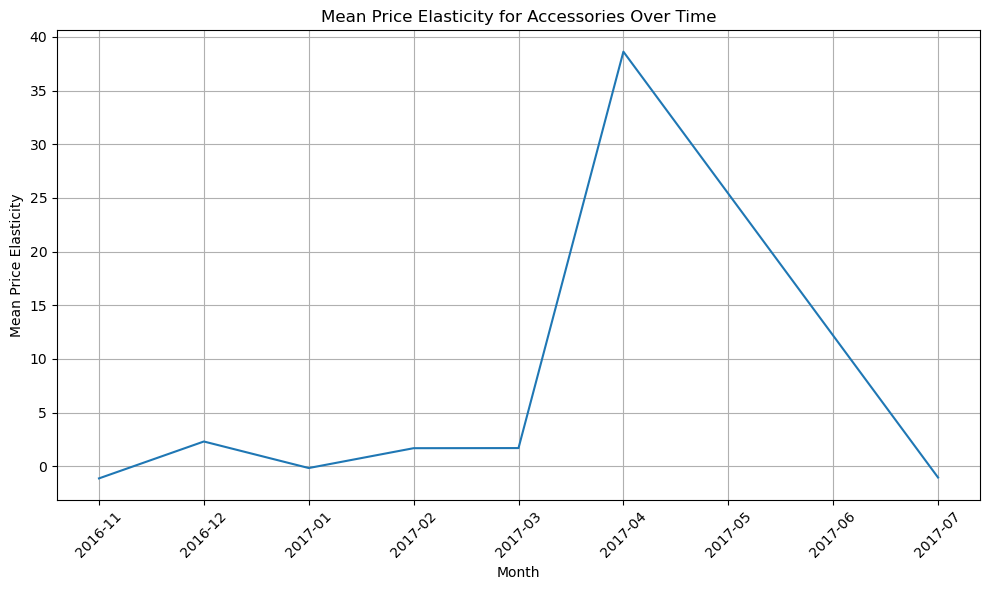

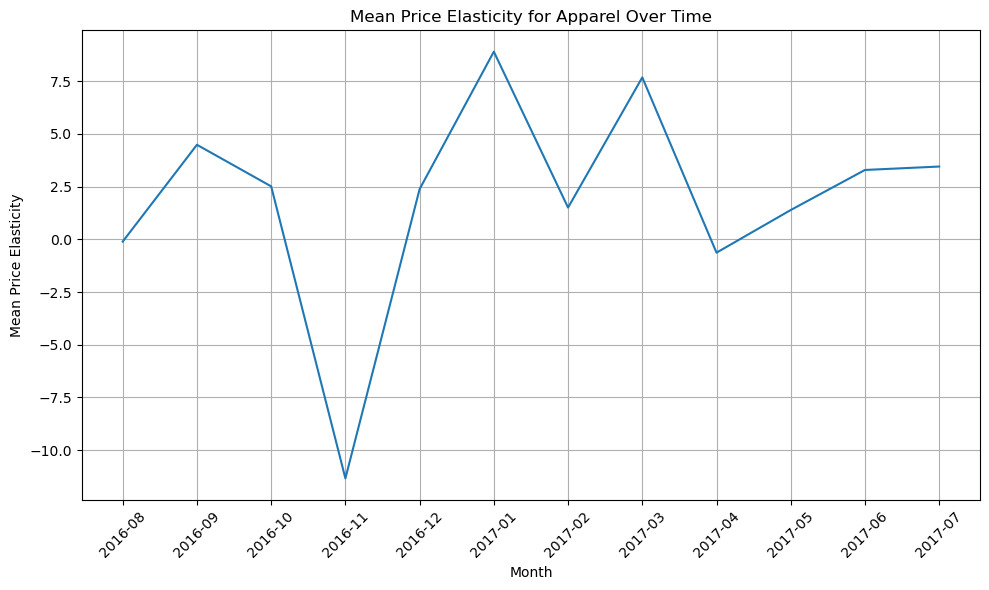

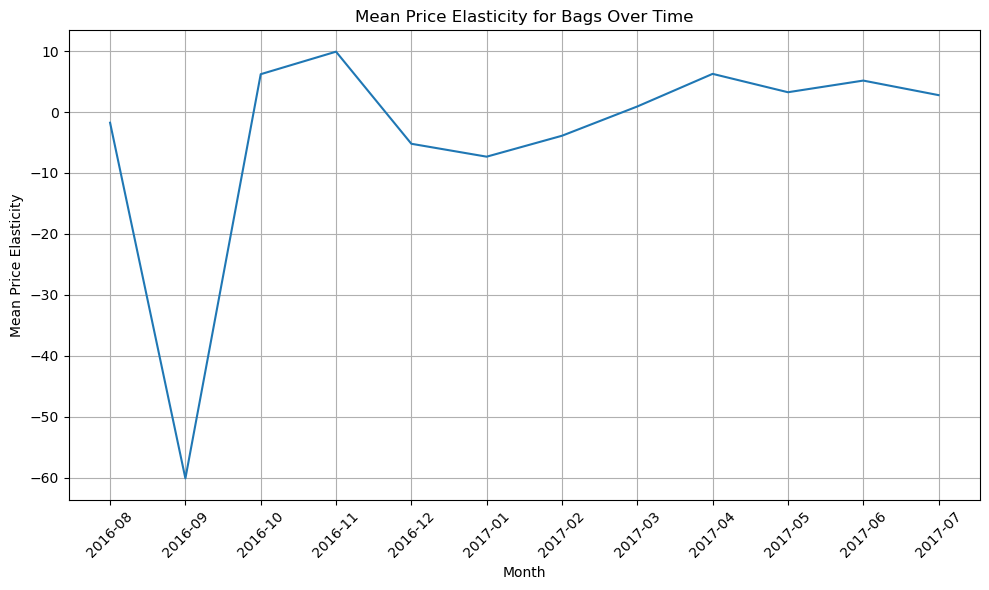

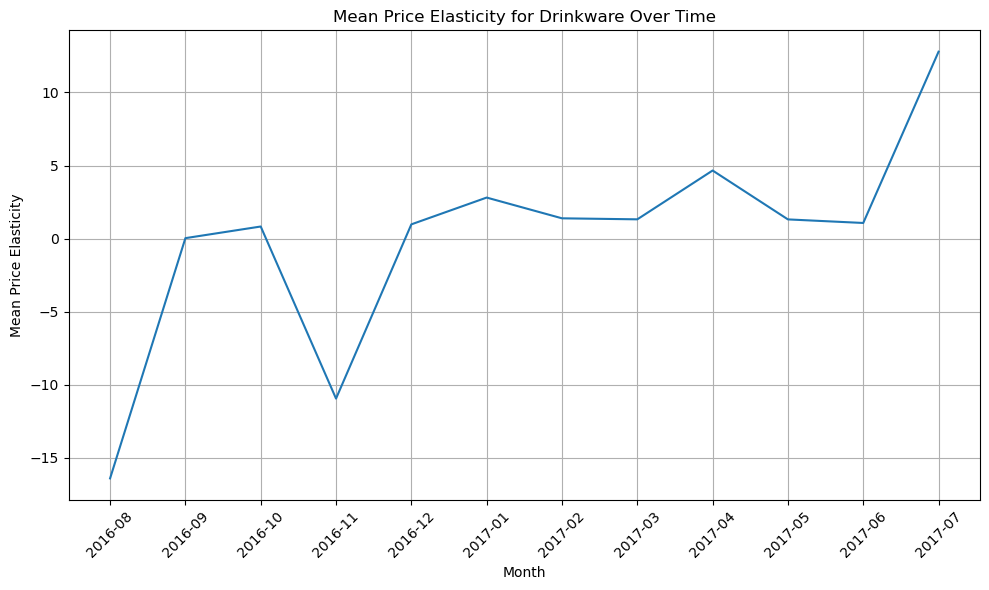

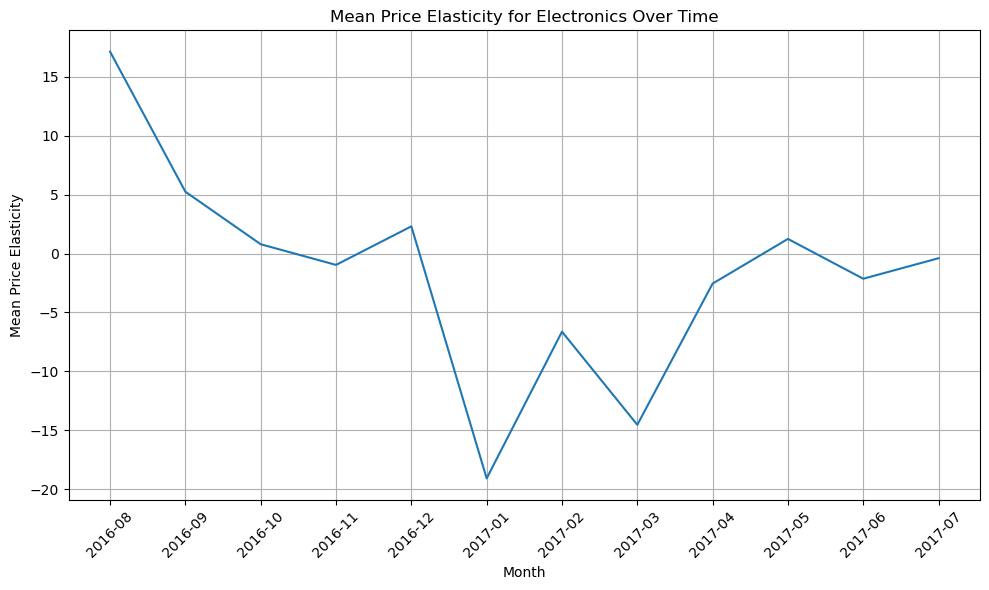

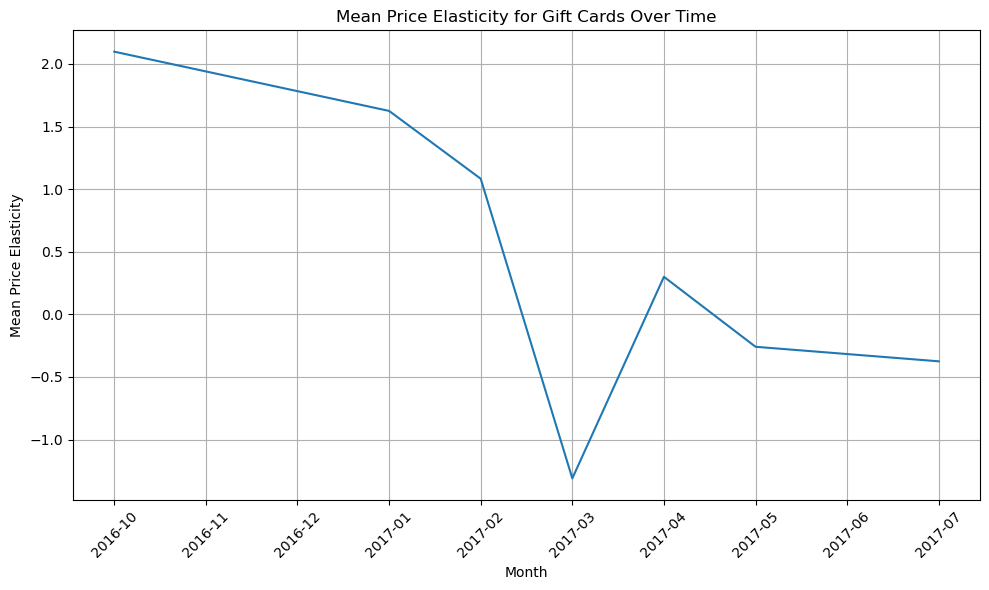

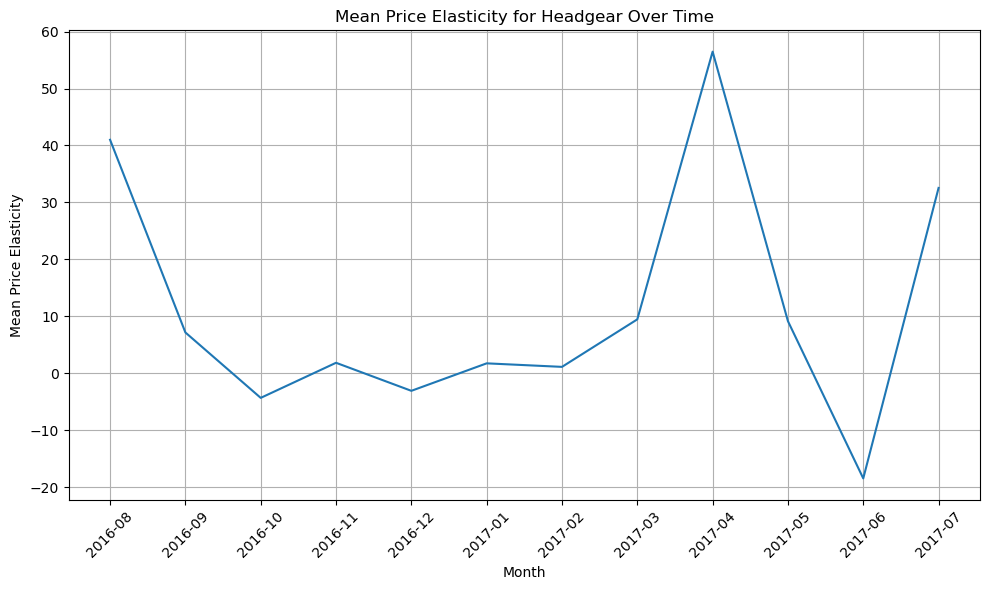

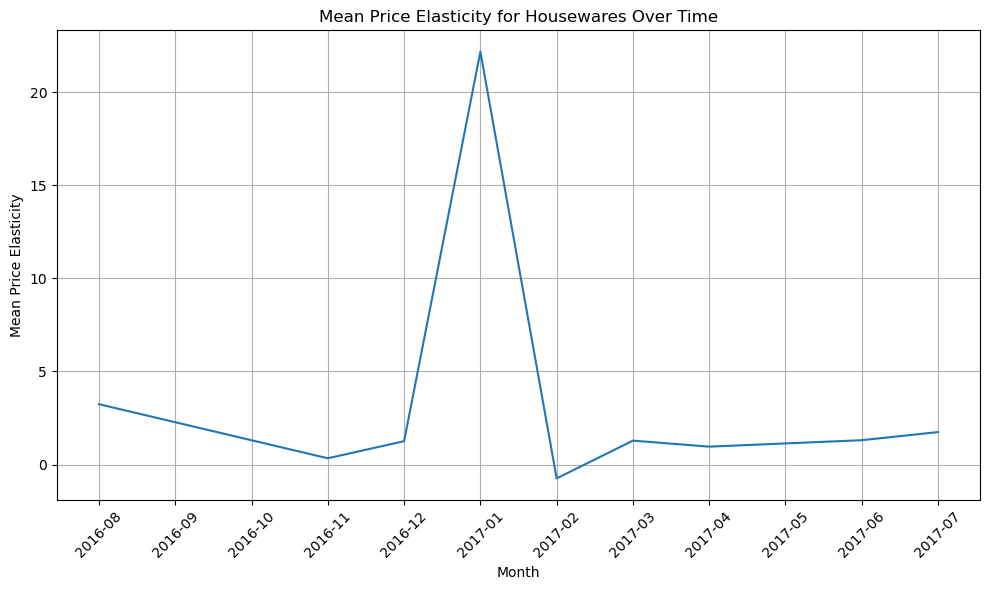

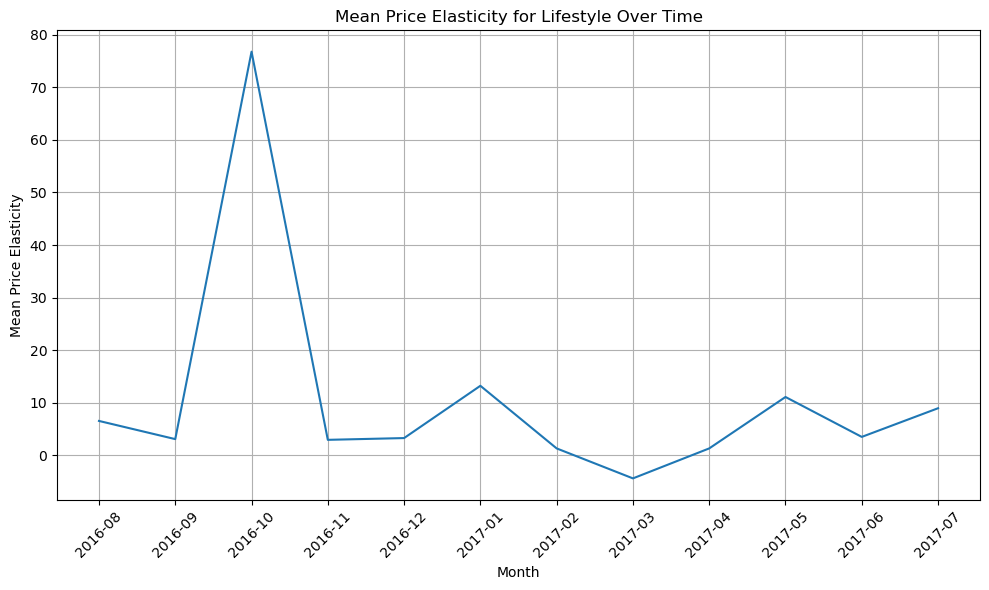

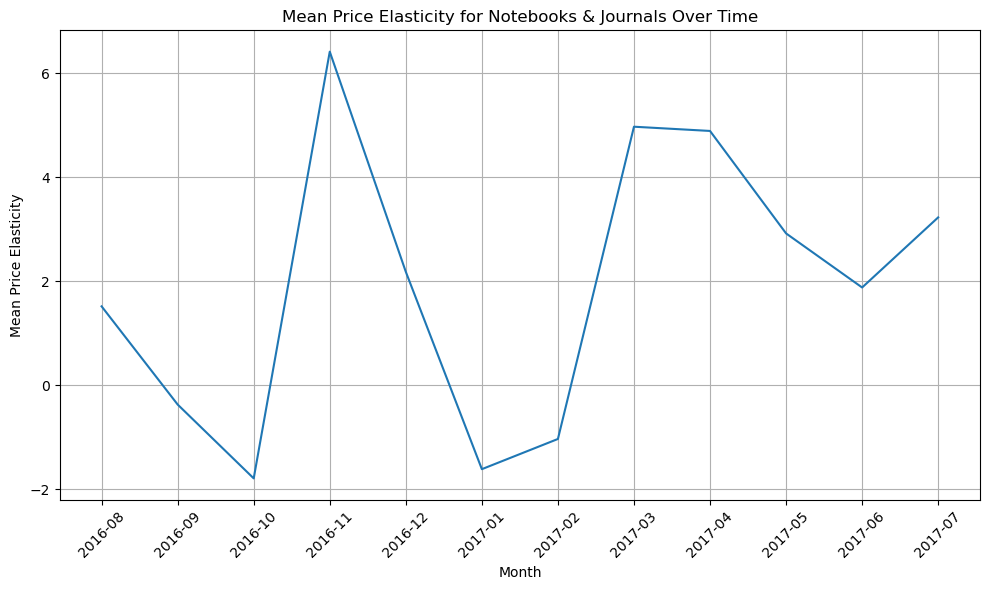

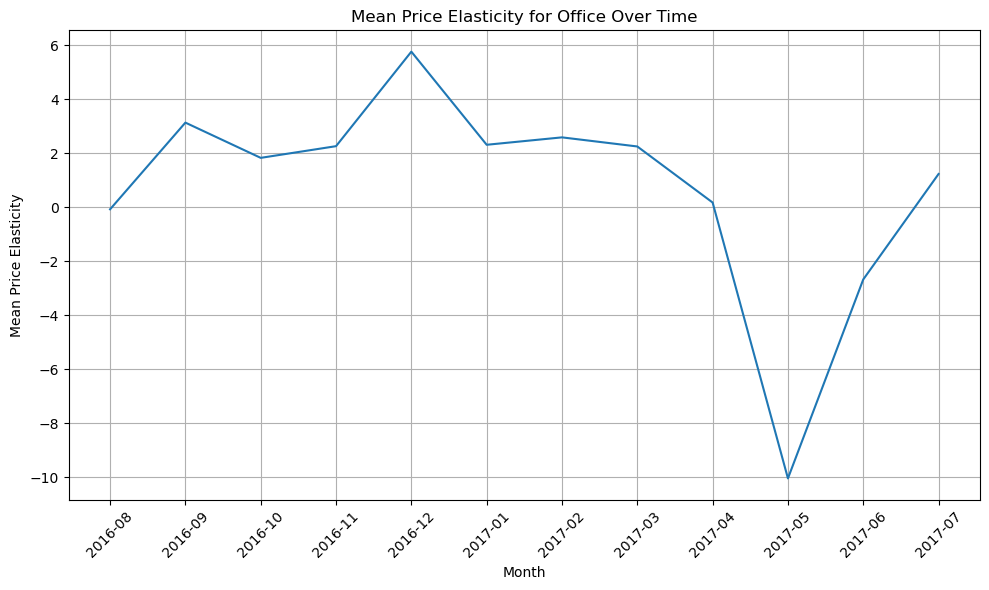

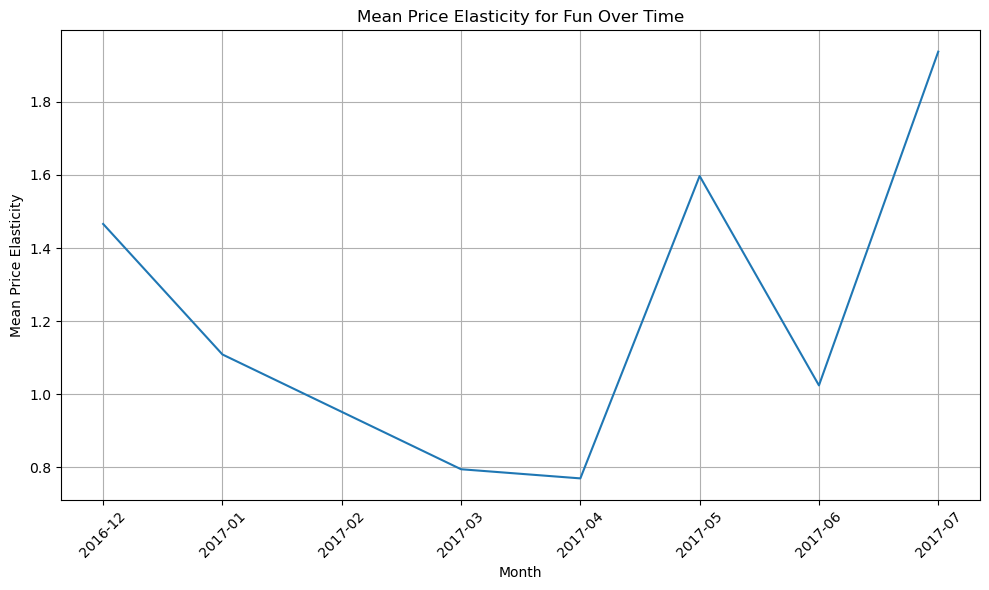

In [90]:
product_categories = monthly_elasticity_summary_clean['product_category'].unique()

# Plot each product category separately
for category in product_categories:
    # Filter the data for the current category
    category_data = monthly_elasticity_summary_clean[monthly_elasticity_summary_clean['product_category'] == category]
    
    # Plot the mean price elasticity over time for the current category
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=category_data, x='month', y='mean_price_elasticity')
    
    # Add labels and title
    plt.title(f'Mean Price Elasticity for {category} Over Time')
    plt.xlabel('Month')
    plt.ylabel('Mean Price Elasticity')
    plt.xticks(rotation=45)
    plt.grid(True)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

## 9. Creating smoother plots

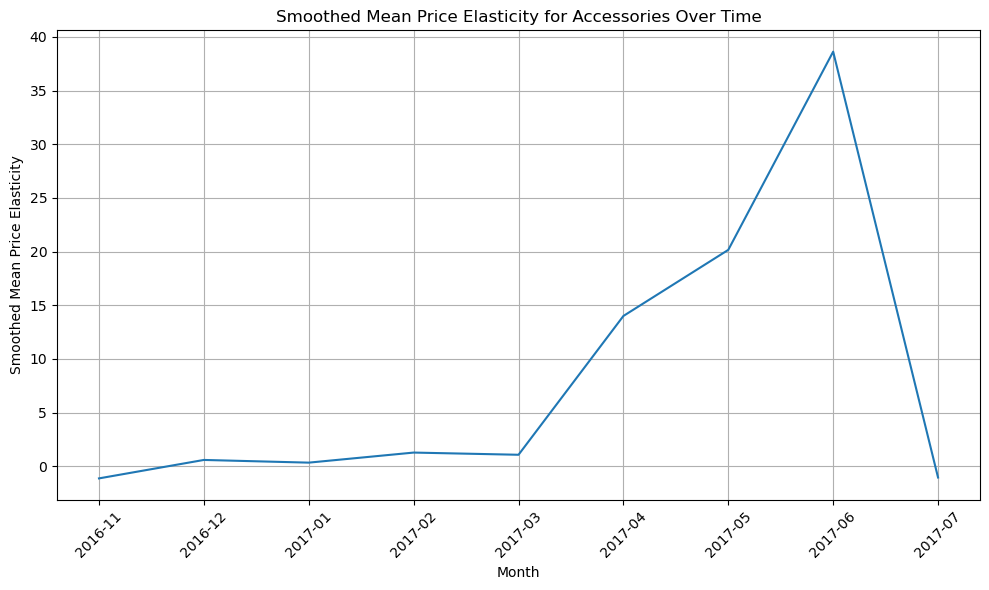

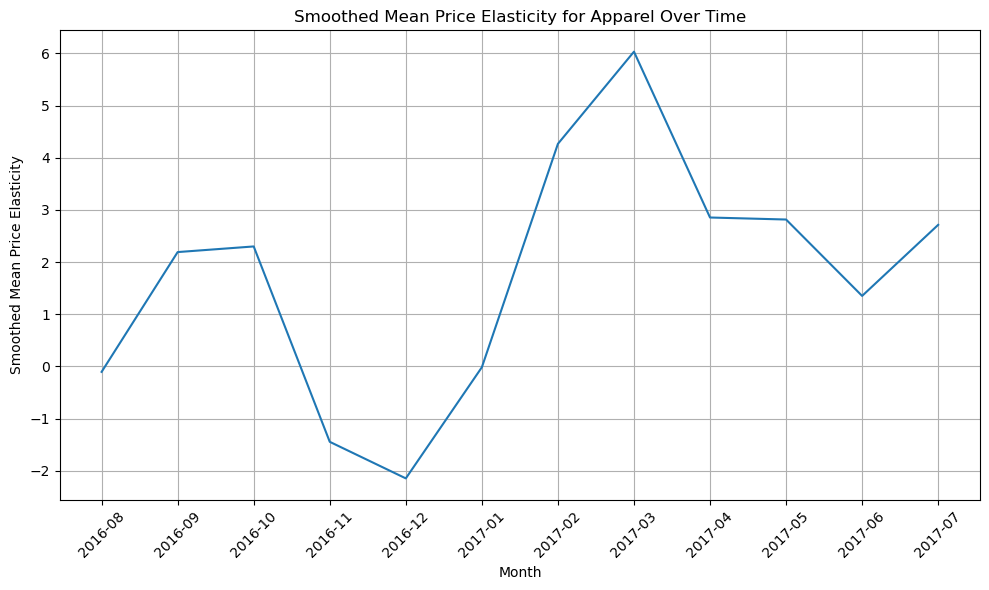

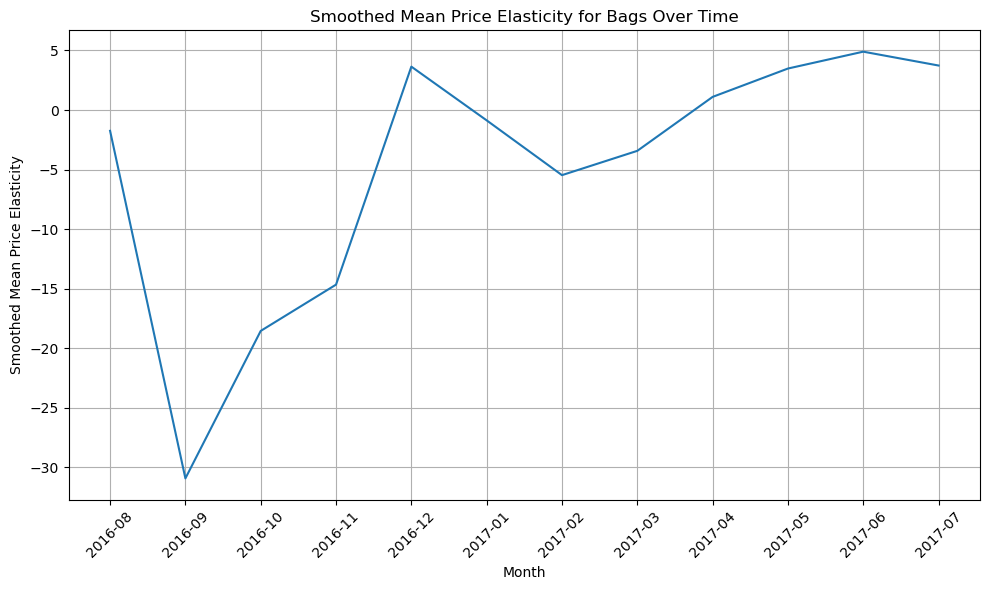

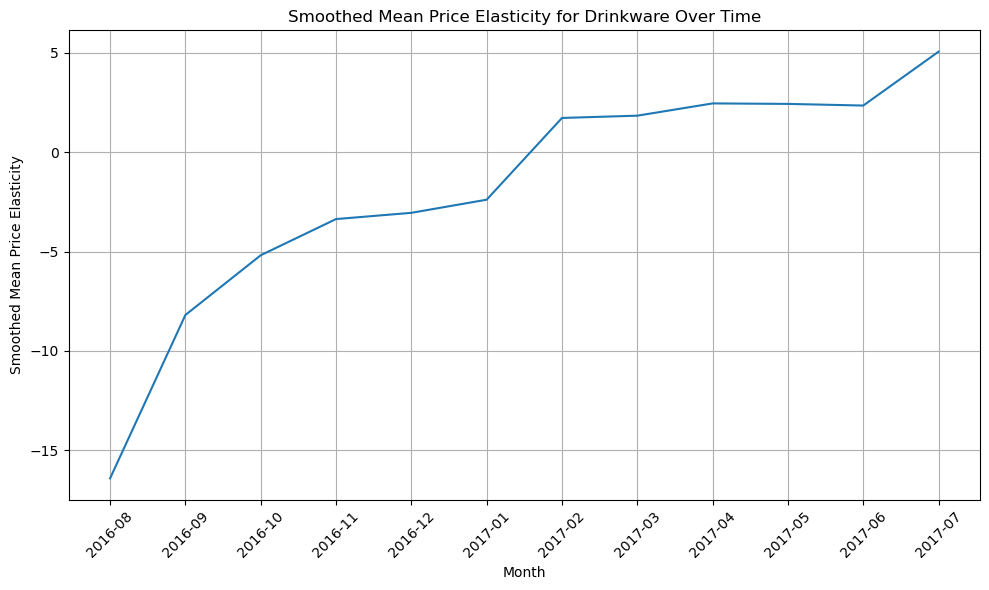

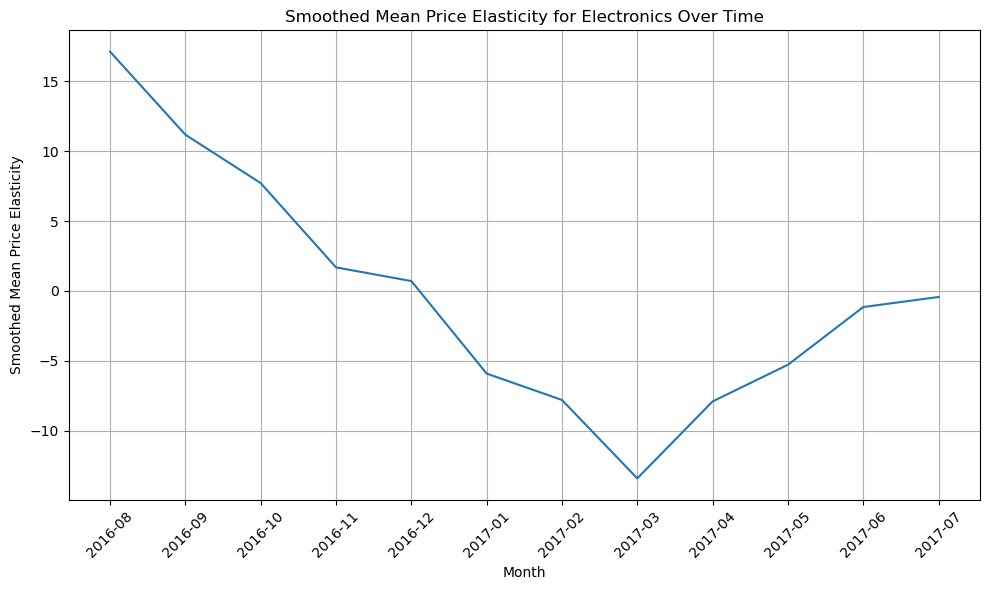

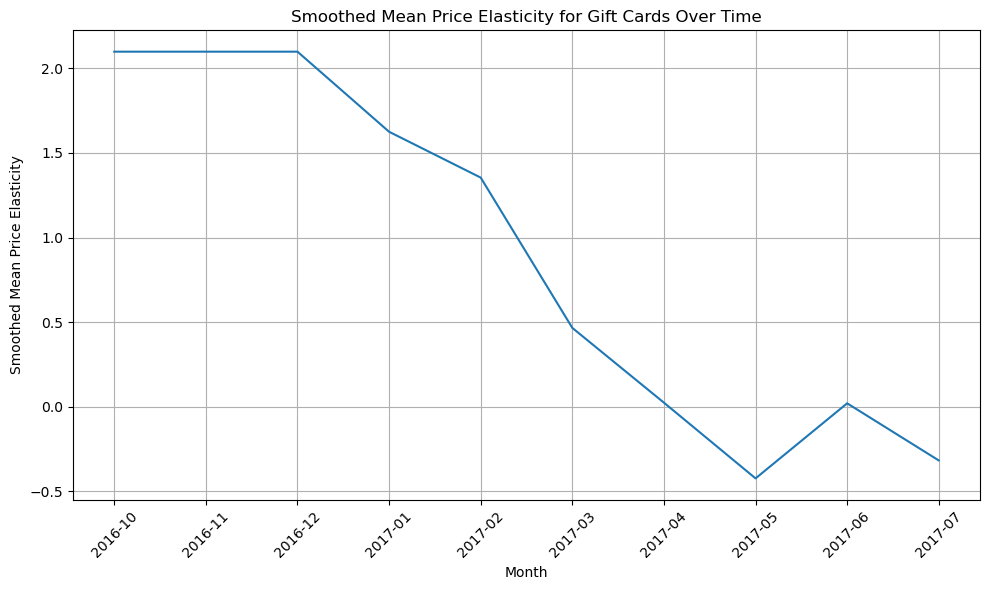

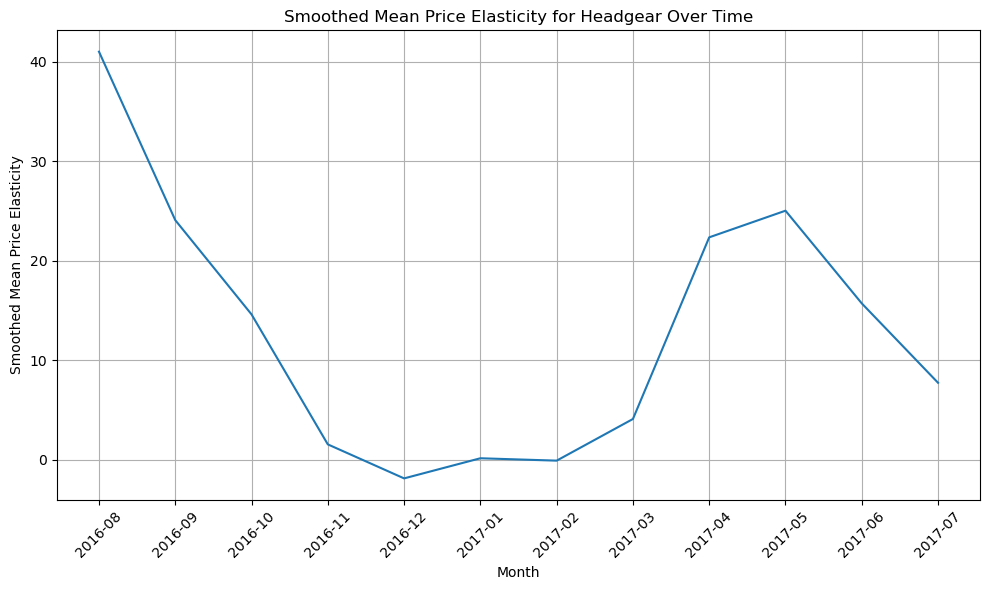

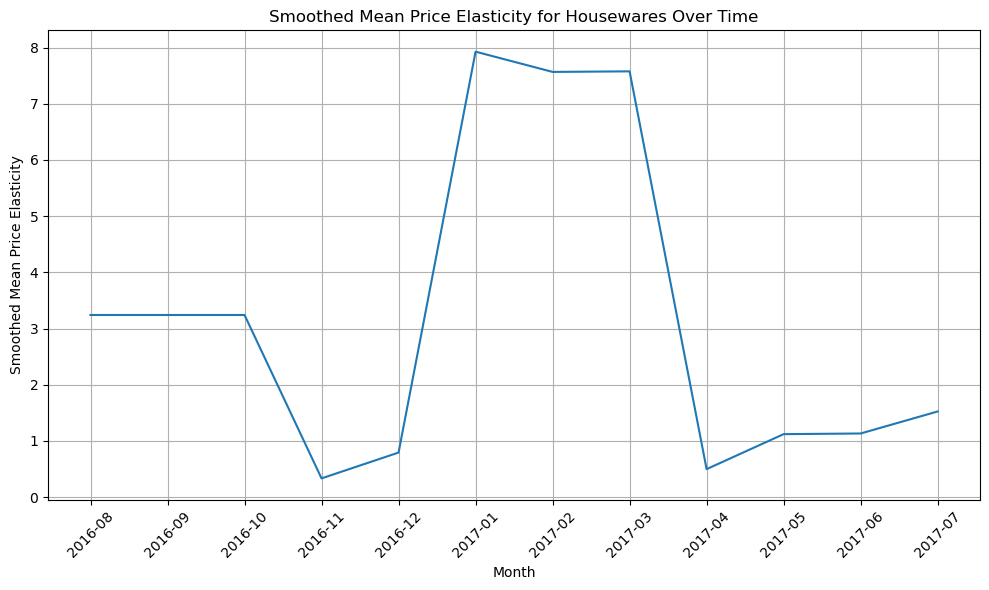

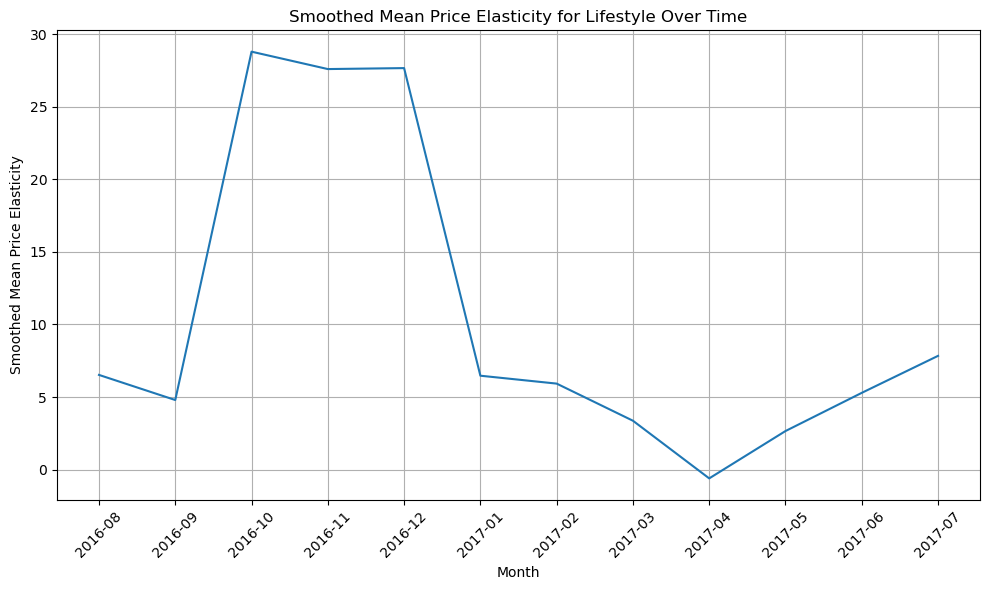

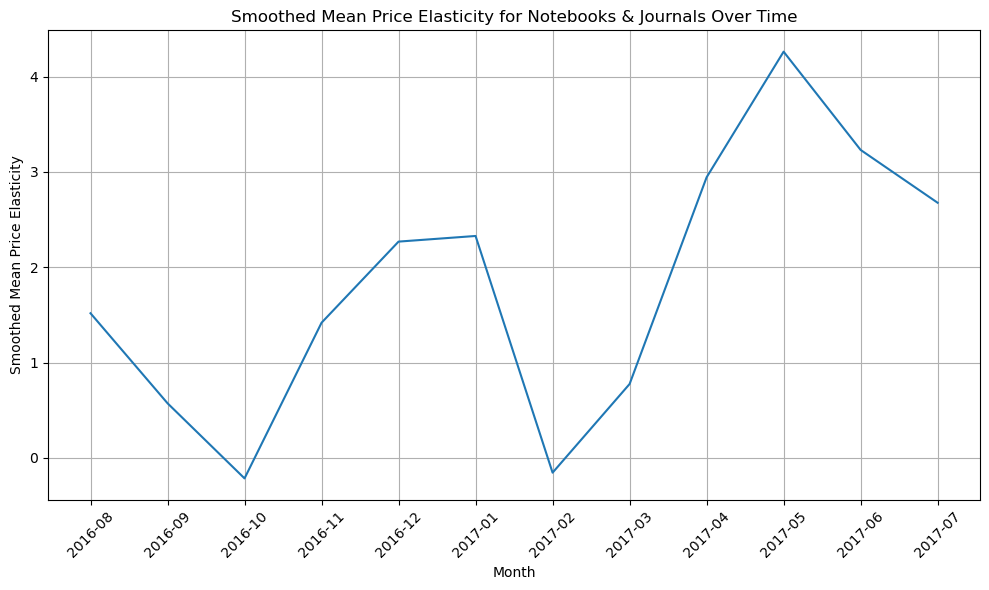

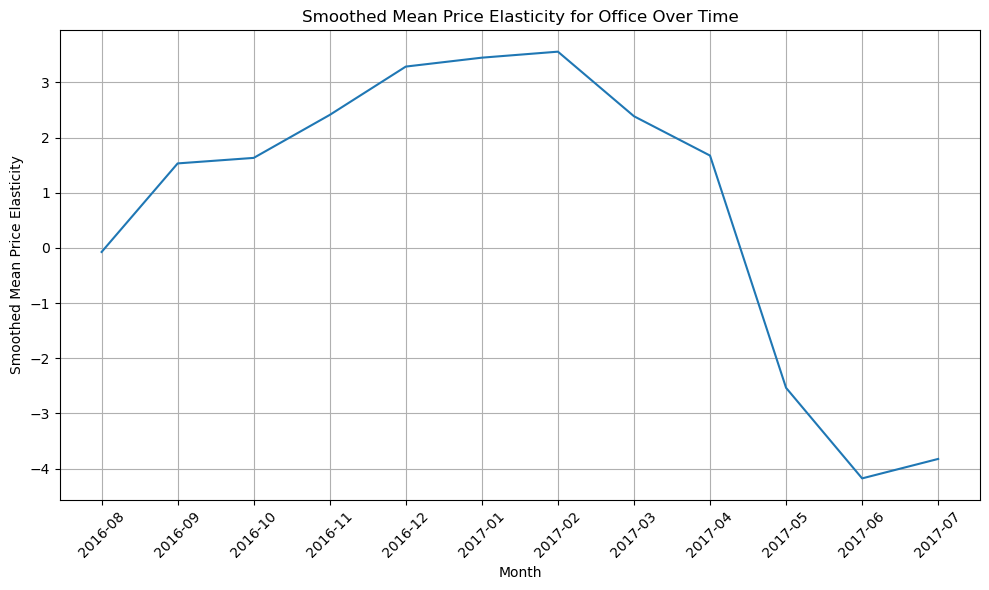

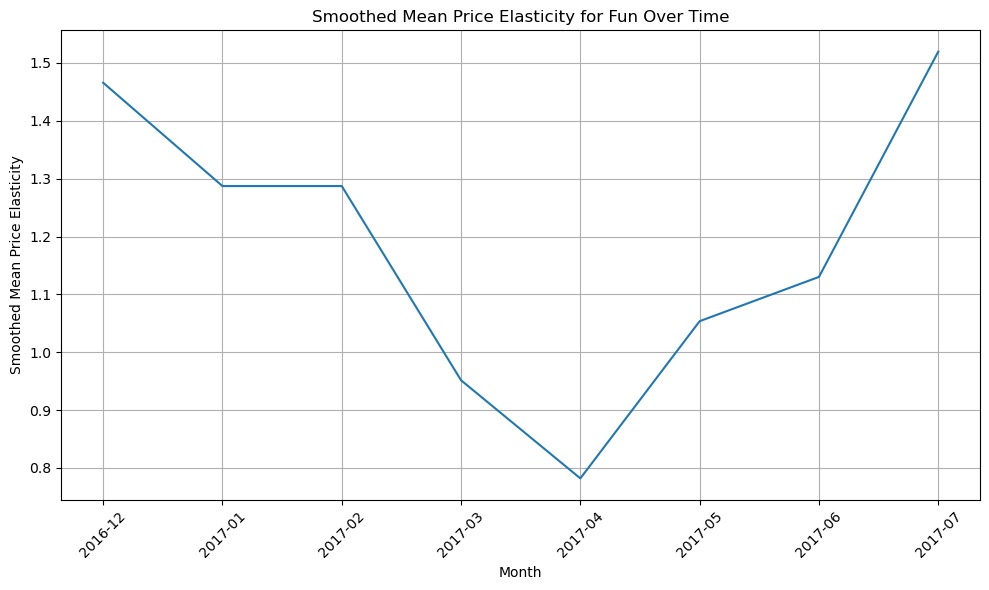

In [81]:
# Apply a rolling mean (moving average) to smooth out the fluctuations
monthly_elasticity_summary['mean_price_elasticity_smoothed'] = monthly_elasticity_summary.groupby('product_category')['mean_price_elasticity'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Plot the smoothed data
for category in product_categories:
    category_data = monthly_elasticity_summary[monthly_elasticity_summary['product_category'] == category]
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=category_data, x='month', y='mean_price_elasticity_smoothed')
    plt.title(f'Smoothed Mean Price Elasticity for {category} Over Time')
    plt.xlabel('Month')
    plt.ylabel('Smoothed Mean Price Elasticity')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# Accessories have increasing price elasticity from November 2016 to June 2017 before a large drop.
# Apparel has volatile price elasticity but magnitude of change is not that big.
# Bags large decrease in price elasticity before sharply increasing again in September 2016.
# Drinkware general trend of increasing price elasticity.
# Electronics have a V-shape
# Gift cards have decreasing price elasticity.
# Headgear decrease then increase then decrease.
# Houseware price elasticity spiked from December 2016 to April 2014 then drop back down.
# Lifestyle products spiked from September 2016 to December then droped back down
# Price elasticity for notebooks and journals volatile but small in magnitude.
# Office slow increasing trend before sharp decrease in April 2017.
# Fun products have V-shape. 